In [1]:
from read_data import *
from hyper import *
from alignment import *
from copy import *
from datasets.preprecossing import *
import rpy2
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster import hierarchy
from math import sin,cos,pi
import scipy

import seaborn as sns

folder_path = './datas/original/'
folder_path2 = './datas/originall/'
pcanum = 20
tempnum = 200

In [2]:
def rotate_spots(grid,spots,theta=0,translation=0,center_correction=0,figsize=(5,5),plot=True):
    grid = grid.copy() + center_correction
    spots = spots.copy() + center_correction
    R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    rotated_spots = np.array([R.dot(spots[i]) for i in range(len(spots))])
    rotated_spots += translation

    new_spots = grid[np.argmin(scipy.spatial.distance.cdist(rotated_spots,grid),axis=1)]

    grid -= center_correction
    spots -= center_correction
    rotated_spots -= center_correction
    new_spots -= center_correction

    seen = {}
    mapping = []
    for i in range(len(new_spots)):
        if tuple(new_spots[i]) in seen: continue
        seen[tuple(new_spots[i])] = 1
        mapping.append(i)

    if plot:
        fig = plt.figure(figsize=figsize)
        sns.scatterplot(x = grid[:,0],y = grid[:,1],linewidth=0,s=100, marker=".",alpha=0.2,color='blue')
        sns.scatterplot(x = rotated_spots[:,0],y = rotated_spots[:,1],linewidth=0,s=100, marker=".",color='red')
        sns.scatterplot(x = new_spots[:,0],y = new_spots[:,1],linewidth=0,s=100, marker=".",color='green')
        plt.show()

    return new_spots,mapping

def simulate_spatial(adata, rotation_angle):
    adata_sim = adata.copy()
    grid_size = 800
    layer_grid = np.array([[x,y] for x in range(grid_size) for y in range(grid_size)])
    new_spots, mappings = rotate_spots(layer_grid, adata.obsm['spatial'], center_correction=-15, theta= rotation_angle)
    adata_sim.obsm['spatial'] = new_spots
    return adata_sim[mappings, :], mappings

In [3]:
def simulate_gene_exp(adata, pc = 0.25, factor = 1):
    """
    Adds noise to gene expression data. The rows are simulated according to a Multinomial distribution, 
    with the total counts per spot drawn from a Negative Binomial Distribution.
    param: pc- Pseudocount to be added to dataframe
    param: factor - amount by which we scale the variance (to increase noise)
    """
    adata_sim = adata.copy()
    df = pd.DataFrame(adata_sim.X.toarray())
    # add pseudocounts 
    alpha = df.copy().to_numpy() + pc

    # get vector of total counts per spot
    n = df.sum(axis=1).to_numpy()

    # Simulate total counts using negative binomial
    mean = np.mean(n)
    var = np.var(n)*factor
    n = sample_nb(mean, var, len(n)).astype(int)

    # Reassign zero counts so we don't divide by 0 in future calcuation
    n[n == 0] = 1

    # convert to float
    alpha = np.array(alpha, dtype=np.float64)
    n = np.array(n, dtype=np.float64)

    # convert rows to unit vectors
    alpha = alpha/alpha.sum(axis=1)[:, None]

    dist = np.empty(df.shape)
    for i in range(alpha.shape[0]):
        dist[i] = np.random.multinomial(n[i], alpha[i])
    new_df = pd.DataFrame(dist, index= df.index, columns= df.columns)
    adata_sim.X = new_df
    return adata_sim

def sample_nb(m, v, n = 1):
    """
    param: m - mean
    param: v - variance
    param: n - number of samples
    return: random sample from negative binomial distribution
    """
    r = m**2/(v - m)
    p = m/v
    samples = np.random.negative_binomial(r, p, n)
    return samples

In [4]:
datas = sc.read_h5ad("./datas/nature/151507_preprocessed.h5")
adata_subset = datas[:tempnum,:]
adata_subset
sc.write('./datas/nature/adata_subset.h5',adata_subset)

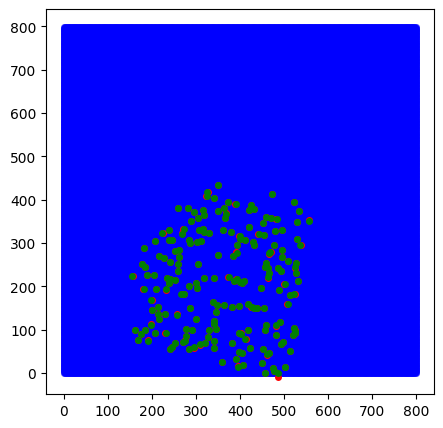

In [5]:
datas = sc.read_h5ad("./datas/nature/adata_subset.h5")
datas = simulate_gene_exp(datas)
datas,m = simulate_spatial(datas,-pi/12);

count_sub = datas.to_df()
xy_coords = pd.DataFrame(datas.obsm['spatial'],columns=['imagerow','imagecol'],index= datas.obs.index)
xy_coords.to_csv(folder_path+"xy.csv")
datas.obs.to_csv(folder_path+'meta_data.csv');
count_sub.T.to_csv(folder_path+"gene.csv")

In [6]:
datas

View of AnnData object with n_obs × n_vars = 200 × 9948
    obs: 'in_tissue', 'array_row', 'array_col', 'imagerow', 'imagecol', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'discard', 'cell_count', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    uns: 'layer_guess_reordered_colors'
    obsm: 'spatial'

In [7]:
# # robjects.r("load(paste0('./datas/pca/DLPFC/LIBD_sample1.RData'))")
# from rpy2.robjects.packages import importr
# import rpy2.robjects as robjects

# Spatialpc  = importr('SpatialPCA')
# ggplot2 = importr('ggplot2')
# matrix = importr('Matrix')
# robjects.r("xy_coords <- read.csv('{}',row.names='X')".format(folder_path + 'xy.csv'))
# robjects.r("xy_coords=as.matrix(xy_coords)")
# robjects.r("count_temp <- read.csv('{}',row.names='X')".format(folder_path + 'gene.csv'))
# robjects.r('my_matrix <- do.call(cbind, count_temp)')
# robjects.r('my_sparse_matrix <- Matrix(my_matrix, sparse = TRUE)')
# robjects.r('count_sub <- as(my_sparse_matrix, "dgCMatrix")')
# robjects.r('rownames(count_sub) <- rownames(count_temp)')
# robjects.r("rownames(xy_coords) = colnames(count_sub)");
# robjects.r('LIBD = CreateSpatialPCAObject(counts=count_sub, location=xy_coords, project = "SpatialPCA",gene.type="spatial",sparkversion="spark",numCores_spark=5,gene.number=3000, customGenelist=NULL,min.loctions = 20, min.features=20)')
# robjects.r('LIBD = SpatialPCA_buildKernel(LIBD, kerneltype="gaussian", bandwidthtype="SJ",bandwidth.set.by.user=NULL)')
# robjects.r('LIBD = SpatialPCA_EstimateLoading(LIBD,fast=FALSE,SpatialPCnum={})'.format(pcanum))
# robjects.r('LIBD = SpatialPCA_SpatialPCs(LIBD, fast=FALSE)')
# robjects.r('write.csv(as.data.frame(LIBD@SpatialPCs), file = "{}")'.format(folder_path + "pca.csv"))

In [8]:
datas.to_df()

,NOC2L,HES4,ISG15,AGRN,C1orf159,TNFRSF18,SDF4,B3GALT6,UBE2J2,ACAP3,...,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC007325.4
AAACAACGAATAGTTC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,6.0,7.0,4.0,0.0,6.0,0.0,0.0,4.0,0.0
AAACAAGTATCTCCCA-1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,22.0,35.0,16.0,4.0,23.0,1.0,0.0,14.0,1.0
AAACAATCTACTAGCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,15.0,11.0,11.0,1.0,14.0,2.0,0.0,6.0,0.0
AAACACCAATAACTGC-1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,2.0,13.0,12.0,6.0,0.0,14.0,1.0,0.0,11.0,0.0
AAACAGCTTTCAGAAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,59.0,64.0,13.0,2.0,50.0,1.0,0.0,32.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AATAAGTCCTCGAGAC-1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,12.0,13.0,1.0,2.0,13.0,0.0,0.0,12.0,0.0
AATACAATGTTTCAGG-1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,8.0,43.0,47.0,28.0,1.0,32.0,7.0,0.0,25.0,2.0
AATACCGGAGGGCTGT-1,1.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,3.0,...,2.0,26.0,33.0,9.0,5.0,29.0,3.0,0.0,14.0,0.0
AATACCTGATGTGAAC-1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,26.0,38.0,10.0,3.0,38.0,3.0,0.0,20.0,0.0


In [9]:
adata1 = datas.to_df()
similarity_matrix = 1 - cosine_similarity(adata1)
n=len(similarity_matrix);
Z = hierarchy.linkage(similarity_matrix, 'ward')

nodes1 = [node(name=str(i),son=[]) for i in range(2*n-1)]
for i in range(n):
    nodes1[i].value = adata1.iloc[i].to_numpy()
for i in range(n-1):
    nodes1[n+i].son.append(nodes1[int(Z[i][0])])
    nodes1[n+i].son.append(nodes1[int(Z[i][1])])
    nodes1[n+i].value = nodes1[n+i].son[0].value  + nodes1[n+i].son[1].value
    nodes1[n+i].value /=2


In [10]:
datas = sc.read_h5ad("./datas/nature/adata_subset.h5")
# datas = simulate_gene_exp(datas)
# datas,m = simulate_spatial(datas,-pi/12);

# count_sub = datas.to_df()
# xy_coords = pd.DataFrame(datas.obsm['spatial'],columns=['imagerow','imagecol'],index= datas.obs.index)
# xy_coords.to_csv(folder_path+"xy.csv")
# datas.obs.to_csv(folder_path+'meta_data.csv');
# count_sub.T.to_csv(folder_path+"gene.csv")

In [11]:
datas.to_df()

,NOC2L,HES4,ISG15,AGRN,C1orf159,TNFRSF18,SDF4,B3GALT6,UBE2J2,ACAP3,...,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC007325.4
AAACAACGAATAGTTC-1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,10.0,12.0,8.0,2.0,8.0,0.0,0.0,5.0,0.0
AAACAAGTATCTCCCA-1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,59.0,81.0,44.0,4.0,75.0,7.0,0.0,50.0,1.0
AAACAATCTACTAGCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,45.0,42.0,32.0,4.0,53.0,13.0,0.0,22.0,0.0
AAACACCAATAACTGC-1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,4.0,25.0,30.0,18.0,0.0,30.0,1.0,1.0,21.0,0.0
AAACAGCTTTCAGAAG-1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,53.0,77.0,21.0,1.0,51.0,7.0,0.0,39.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AATAAGTCCTCGAGAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,18.0,22.0,3.0,1.0,18.0,3.0,0.0,20.0,0.0
AATACAATGTTTCAGG-1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,65.0,85.0,40.0,0.0,54.0,8.0,1.0,44.0,0.0
AATACCGGAGGGCTGT-1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,3.0,17.0,29.0,8.0,1.0,25.0,5.0,0.0,16.0,0.0
AATACCTGATGTGAAC-1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,45.0,70.0,26.0,3.0,50.0,8.0,0.0,34.0,0.0


In [12]:
adata2 = datas.to_df()
# adata2 = adata2.set_index(adata2.columns[0]).T
# adata2.index = adata2.index.str.replace('.', '-')
similarity_matrix = 1 - cosine_similarity(adata2)
n=len(similarity_matrix);
Z = hierarchy.linkage(similarity_matrix, 'ward')

nodes2 = [node(name=str(i),son=[]) for i in range(2*n-1)]
for i in range(n):
    nodes2[i].value = adata2.iloc[i].to_numpy()
for i in range(n-1):
    nodes2[n+i].son.append(nodes2[int(Z[i][0])])
    nodes2[n+i].son.append(nodes2[int(Z[i][1])])
    nodes2[n+i].value = nodes2[n+i].son[0].value  + nodes2[n+i].son[1].value
    nodes2[n+i].value /=2


In [13]:
T=tree_alignment(nodes1[-1],nodes2[-1],1);
minn = T.run_alignment();
T.show_ans();
ans = T.get_ans()


The mininum cost for alignment is 432.45362840978675
The alignment edges list is [('398', '398'), ('397', '397'), ('395', '392'), ('392', '391'), ('383', '384'), ('344', '362'), ('315', '342'), ('275', '320'), ('259', '289'), ('239', '261'), ('158', '13'), ('132', '59'), ('237', '264'), ('223', '253'), ('216', '239'), ('167', '50'), ('160', '143'), ('142', '145'), ('66', '109'), ('244', '301'), ('227', '255'), ('140', '78'), ('17', '108'), ('135', '12'), ('272', '267'), ('246', '241'), ('230', '226'), ('183', '183'), ('39', '40'), ('228', '215'), ('176', '9'), ('127', '165'), ('224', '149'), ('280', '341'), ('263', '321'), ('248', '249'), ('232', '233'), ('229', '219'), ('143', '161'), ('103', '141'), ('98', '140'), ('5', '154'), ('234', '235'), ('120', '34'), ('1', '175'), ('243', '308'), ('217', '244'), ('186', '10'), ('70', '70'), ('32', '225'), ('327', '373'), ('284', '365'), ('242', '337'), ('215', '266'), ('196', '1'), ('94', '117'), ('214', '325'), ('209', '303'), ('148', '126')

In [14]:
minn/2/(2*n-1)

0.5419218401125148

In [15]:
all = n;
count =0;
for i in range(n):
    if(ans.__contains__( (str(i),str(i)) ) ):
        count +=1
print(count/all);

0.03
